In [1]:
import torch
import random
import scipy
import os
from PIL import Image
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import math
import time
import matplotlib.image
import pprint
import datetime
import torch
import numpy as np
from PIL import Image
from datetime import timedelta
start = time.time()
cuda_opt = True
if torch.cuda.is_available() & cuda_opt:
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    

In [2]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [3]:
def read_image(file_name):
    image_path = "/mnt/Data/darijani/AdaLISTA/natural_images/"+str(file_name)
    X = (torch.from_numpy(io.imread(image_path)).to(torch.cdouble)).to(DEVICE)/255.0
    return X

def show_image(X):
    # image_path = "/mnt/Data/darijani/AdaLISTA/natural_images/"+str(file_name)
    # X = (torch.from_numpy(io.imread(image_path)).to(torch.cdouble)).to(DEVICE)/255.0
    image = torch.abs(X)
    image = image/torch.max(image)
    image = image*255.0
    image = image.detach().cpu().numpy().astype(int)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def save_image(Xhats,N,name):
    # X = Xhats[:,:,:,N]
    X = torch.abs(Xhats)
    numpy_array = X.detach().cpu().numpy()
    # Convert the NumPy array to a PIL image
    pil_image = Image.fromarray((numpy_array * 255).astype(np.uint8))

    # Save the PIL image as a PNG image
    output_path =  "/mnt/Data/darijani/AdaLISTA/natural_images/wf_reconstructed/"
    file_name = 'wf_reconstructed_'+str(N)+"_"+name+'.png'
    pil_image.save(output_path+file_name)

def image_err(X_recons,X):
    error = torch.linalg.norm(X_recons-X)/torch.linalg.norm(X)  
    return error

def save_reconstructeds(Xhats):
    N = Xhats.shape[3]
    for tt in range(0,N):

        save_image(Xhats[:,:,:,tt],tt)
# show_image("dc.jpg")
def distance_update(x,z):
    result = torch.exp(-1j*torch.angle(torch.trace(torch.matmul(x.H,z))))*z
    return result

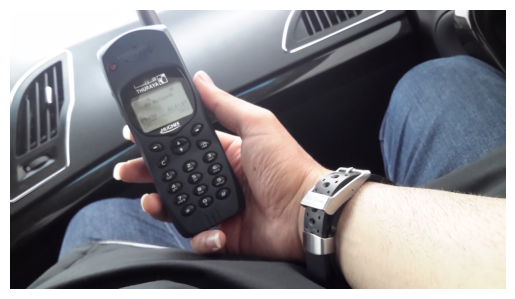

torch.Size([563, 1000, 3])


In [4]:
file_name = "sat_phone"
extension = "jpg"
# file_name = input('Enter the Name of The File.')
# extension = input('Enter the Extension of The File.')

path = "/mnt/Data/darijani/AdaLISTA/natural_images/"+str(file_name)+"."+str(extension)
# os.mkdir(file_name)
X = read_image(str(file_name)+"."+str(extension))
show_image(X)
n1, n2 = X.shape[:2]
n_chan = X.shape[2]
L = 21
T_max = 500 
npower_iter = 50                      
tau0 = 330    
err = np.zeros((T_max,n_chan))

                          
def mu(t):
    return min(1-math.exp(-t/tau0), 0.4)

Masks_1 = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
Masks_2 = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
for ll in range(L):
    Masks_1[:,:,ll] = torch.from_numpy(np.random.choice([1,-1,1j,-1j], (n1,n2), p=[1/4, 1/4, 1/4, 1/4])).to(DEVICE)
    Masks_2[:,:,ll] = torch.from_numpy(np.random.choice([1/math.sqrt(2),math.sqrt(3)], (n1,n2), p=[4/5, 1/5])).to(DEVICE)

Masks = torch.mul(Masks_1,Masks_2)
print(X.shape)


In [5]:

print(torch.norm(X))


tensor(737.2259, device='cuda:0', dtype=torch.float64)


In [6]:
### Make Linear Operators
def A(I):
    conj = torch.conj_physical(Masks)
    measurements = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
    for ll in range(L):
        measurements[:,:,ll] = torch.fft.fft2(torch.mul(conj[:,:,ll],I))
        
    return measurements

def At(Y):
    ifft_Y = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
    for ll in range(L):
        ifft_Y[:,:,ll] = torch.fft.ifftn(Y[:,:,ll])
    product = torch.mul(Masks , ifft_Y)
    summed = torch.sum(product, dim=2)
    size_y1 = Y.size(0)
    size_y2 = Y.size(1)
    result = summed * size_y1 * size_y2
    
    return result



In [7]:

#############################################################
x_r = torch.squeeze(X[:,:,0])
x_g = torch.squeeze(X[:,:,1])
x_b = torch.squeeze(X[:,:,2])
#############################################################
Y_r = torch.abs(A(x_r))**2 
Y_g = torch.abs(A(x_g))**2 
Y_b = torch.abs(A(x_b))**2
#############################################################
z0_r = torch.randn(n1,n2,dtype=torch.cdouble,device=DEVICE)
z0_r = z0_r/torch.linalg.norm(z0_r,'fro')
z0_g = torch.randn(n1,n2,dtype=torch.cdouble,device=DEVICE)
z0_g = z0_g/torch.linalg.norm(z0_g,'fro')
z0_b = torch.randn(n1,n2,dtype=torch.cdouble,device=DEVICE)
z0_b = z0_b/torch.linalg.norm(z0_b,'fro') 
############################################
X_recons = torch.zeros(X.shape,dtype=torch.cdouble,device=DEVICE)





In [8]:

print(torch.mean(x_r))


tensor(0.4760+0.j, device='cuda:0', dtype=torch.complex128)


In [9]:
## initialization for the three channels

for tt in range(0,npower_iter):
    z0_r = At(A(z0_r)) 
    z0_r = z0_r/torch.norm(z0_r,'fro')
    z0_g = At(A(z0_g)) 
    z0_g = z0_g/torch.norm(z0_g,'fro')
    z0_b = At(A(z0_b)) 
    z0_b = z0_b/torch.norm(z0_b,'fro')
normest_r = torch.sqrt(torch.sum(Y_r)/torch.numel(Y_r))
normest_g = torch.sqrt(torch.sum(Y_g)/torch.numel(Y_g))
normest_b = torch.sqrt(torch.sum(Y_b)/torch.numel(Y_b))
z_r = normest_r * z0_r
z_g = normest_g * z0_g
z_b = normest_b * z0_b

print(normest_r)
print(normest_g)
print(normest_b)

X_recons[:,:,0] = distance_update(x_r,z_r)
X_recons[:,:,1] = distance_update(x_g,z_g)
X_recons[:,:,2] = distance_update(x_b,z_b)
save_image(X_recons,-1,file_name)



tensor(428.5580, device='cuda:0', dtype=torch.float64)
tensor(420.9625, device='cuda:0', dtype=torch.float64)
tensor(427.6684, device='cuda:0', dtype=torch.float64)


In [14]:
####### main rule ######
########################
########################


for t in range(0,T_max):

###### red channel update ######
################################
    X_recons[:,:,0] = distance_update(x_r,z_r)
    err[t,0] = image_err(X_recons[:,:,0],X[:,:,0])
    # print("iteration:",t,"error in the red channel:",image_err(X_recons[:,:,0],X[:,:,0]))
    Bz_r = A(z_r)
    C_r  = torch.mul(torch.abs(Bz_r)**2-Y_r , Bz_r)
    grad_r = At(C_r)/torch.numel(C_r)     
    z_r = z_r - (mu(t)/normest_r**2) * grad_r 
###### green channel update ######
################################
    X_recons[:,:,1] = distance_update(x_g,z_g)
    err[t,1] = image_err(X_recons[:,:,1],X[:,:,1])
    # print("iteration:",t,"error in the green channel:",image_err(X_recons[:,:,1],X[:,:,1]))
    Bz_g = A(z_g)
    C_g  = torch.mul(torch.abs(Bz_g)**2-Y_g , Bz_g)
    grad_g = At(C_g)/torch.numel(C_g)     
    z_g = z_g - (mu(t)/normest_g**2) * grad_g
###### blue channel update ######
################################
    X_recons[:,:,2] = distance_update(x_b,z_b)
    err[t,2] = image_err(X_recons[:,:,2],X[:,:,2])
    # print("iteration:",t,"error in the blue channel:",image_err(X_recons[:,:,2],X[:,:,2]))
    Bz_b = A(z_b)
    C_b  = torch.mul(torch.abs(Bz_b)**2-Y_b , Bz_b)
    grad_b = At(C_b)/torch.numel(C_b)     
    z_b = z_b - (mu(t)/normest_b**2) * grad_b

##### saving the image at the iteration #####
#############################################
    save_image(X_recons,t,file_name)
    


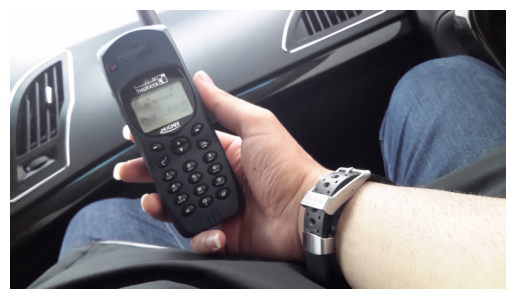

tensor(2.5669e-16, device='cuda:0', dtype=torch.float64)

In [ ]:
show_image(X_recons)
image_err(X_recons[:,:,0],X[:,:,0])



In [ ]:

np.save("./wf_reconstructed/wf_error_"+str(file_name)+"_"+str(T_max)+"_"+str(file_name)+".npy",err)


In [ ]:

# plt.style.use("ggplot")


plt.semilogy(np.arange(0, err.shape[0]), err[:,0], '-r',label="R Channel Error")
plt.semilogy(np.arange(0, err.shape[0]), err[:,1], '-g',label="G Channel Error")
plt.semilogy(np.arange(0, err.shape[0]), err[:,2], '-b',label="B Channel Error")
plt.xlabel("Iteration Number")
plt.ylabel("Relative Error")
plt.legend()
fig = plt.gcf()
tikzplotlib_fix_ncols(fig)
plt.title("Coded Diffaction Pattern Combined with \n Wirtinger Flow on the Sat Phone Image")
plt.grid(True)
# plt.show()
import tikzplotlib
tikzplotlib.save("./wf_reconstructed/wf_error_"+str(file_name)+"_"+str(T_max)+"_"+str(file_name)+".tex")
plt.close()






In [ ]:
def distance(x_r,z_r):
    x_r_f = torch.flatten(x_r)
    z_r_f = torch.flatten(z_r)
    error = torch.linalg.norm(x_r_f - torch.exp(-1j*torch.angle(torch.matmul(x_r_f,z_r_f))) * z_r_f)/torch.linalg.norm(x_r_f)
    return error
print(distance(X_recons,X))


tensor(3.3307e-16, device='cuda:0', dtype=torch.float64)


: 